In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn

import logging
logging.basicConfig(level=logging.INFO)

from robo.initial_design.init_random_uniform import init_random_uniform

seaborn.set_style(style='whitegrid')

#plt.rc('text', usetex=True)
#plt.rc('font', size=15.0, family='serif')
#plt.rcParams['figure.figsize'] = (10.0, 8.0)
#plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

# Model

In [95]:
def objective(x, task):
    if task == 0:
        y = 0.5 * np.sin(3 * x[0]) * 4 * (x[0] - 1) * (x[0] + 2) + x[1]
    elif task == 1:
        y = np.sin(3 * x[0]) * 4 * (x[0] - 1) * (x[0] + 2) + x[1]
    return max(y, 1), task + 1

In [2]:
import os
import sys
import json
import logging
import numpy as np
import pandas as pd
from scipy import sparse
import time
import math

logging.basicConfig(level=logging.INFO)

from robo.fmin import mtbo
from sklearn import svm
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import average_precision_score
from sklearn.ensemble import RandomForestClassifier

df = pd.read_csv(r"C:\Users\t-fufang\OneDrive - Microsoft\AMLdata\ag_news.csv")
df.columns = ['target', 'word']
X_train, X_test, y_train, y_test = train_test_split(df.word, df.target, train_size = 0.7, random_state=2019)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size = 0.4, random_state = 2019)
cv = CountVectorizer(ngram_range = (1, 1))
X_train = cv.fit_transform(X_train)
X_val = cv.transform(X_val)
X_test = cv.transform(X_test)


In [3]:
incumbent = [8.04043589 ,-3.68145332]
train = sparse.vstack((X_train, X_val))
target = np.concatenate((y_train.tolist(), y_val.tolist()))
clf = svm.SVC(gamma=np.exp(incumbent[1]), C=np.exp(incumbent[0]), probability = True)

clf.fit(X_train, y_train)

# Validate this hyperparameter configuration on the full validation data
y_pred = clf.predict_proba(X_test)
y_valid_bin = LabelBinarizer().fit_transform(y_test)
y = roc_auc_score(y_valid_bin, y_pred, average='weighted')
print(y)

0.9715916219101806


In [3]:
# mtbo with auxiliary task on 25% data
lower = np.ones(2) * (-10)
upper = np.ones(2) * 10
def objective(x, task):
    if task == 0:
        dataset_fraction = .25
    elif task == 1:
        dataset_fraction = 1

    s_max = y_train.shape[0]
    shuffle = np.random.permutation(np.arange(s_max))
    s = int(s_max * dataset_fraction)
    train_subset = X_train[shuffle[:s]]
    train_targets_subset = y_train.to_numpy()[shuffle[:s]]

    start_time = time.time()
    # Train the SVM on the subset set
    C = np.exp(float(x[0]))
    gamma = np.exp(float(x[1]))
    clf = svm.SVC(gamma=gamma, C=C, probability = True)
    clf.fit(train_subset, train_targets_subset)
    
    # Validate this hyperparameter configuration on the full validation data
    y_pred = clf.predict_proba(X_val)
    y_valid_bin = LabelBinarizer().fit_transform(y_val)
    y = 1 - roc_auc_score(y_valid_bin, y_pred, average='weighted')
    #y = 1 - clf.score(X_test, y_test)
    c = time.time() - start_time
    return y, c

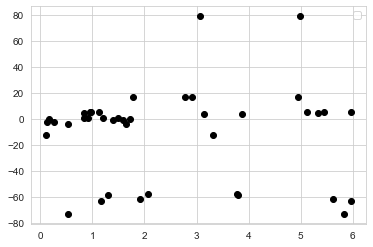

In [56]:
grid = np.linspace(0, 6, 100)

#f_t0 = np.array([objective(np.array([[xi]]), 0) for xi in grid])
#f_t1 = np.array([objective(np.array([[xi]]), 1) for xi in grid])

#plt.plot(grid, f_t0, "r--", label="Task-0")
#plt.plot(grid, f_t1, "b--", label="Task-1")

lower = np.zeros(2)
upper = np.ones(2) * 6

X = np.random.rand(20, 2) * 6
#X = init_random_uniform(lower, upper, 20)
y_t0 = np.array([objective(xi, 0)[0] for xi in X[:15]])
y_t1 = np.array([objective(xi, 1)[0] for xi in X[15:]])
y = np.hstack((y_t0, y_t1))

c_t0 = np.array([objective(xi, 0)[1] for xi in X[:15]])
c_t1 = np.array([objective(xi, 1)[1] for xi in X[15:]])
c = np.hstack((c_t0, c_t1))

t_idx = np.zeros([20])
t_idx[15:] = 1 

plt.plot(X, y, "ko")

X = np.append(X, t_idx[:, None], axis=1)


plt.legend()
plt.show() 

In [4]:
import george
from robo.models.mtbo_gp import MTBOGPMCMC
from robo.priors.env_priors import MTBOPrior



# Define model for the objective function
n_init = 10
cov_amp = 1  # Covariance amplitude
n_dims = lower.shape[0]
n_tasks = 2
n_hypers = 20
chain_length = 200
burnin = 100

X = []
y = []
c = []
incumbents = []

kernel = cov_amp

# ARD Kernel for the configuration space
for d in range(n_dims):
    kernel *= george.kernels.Matern52Kernel(np.ones([1]) * 0.01,
                                            ndim=n_dims+1, dim=d)

task_kernel = george.kernels.TaskKernel(n_dims+1, n_dims, n_tasks)
kernel *= task_kernel

# Take 3 times more samples than we have hyperparameters
if n_hypers < 2*len(kernel):
    n_hypers = 3 * len(kernel)
    if n_hypers % 2 == 1:
        n_hypers += 1

prior = MTBOPrior(len(kernel) + 1,
                  n_ls=n_dims,
                  n_kt=len(task_kernel))

model = MTBOGPMCMC(kernel, prior=prior,
                             burnin_steps=burnin,
                             chain_length=chain_length,
                             n_hypers=n_hypers,
                             lower=lower,
                             upper=upper)


cost_cov_amp = 1
cost_kernel = cost_cov_amp
for d in range(n_dims):
    cost_kernel *= george.kernels.Matern52Kernel(np.ones([1]) * 0.01,
                                                 ndim=n_dims+1, dim=d)

cost_task_kernel = george.kernels.TaskKernel(n_dims+1, n_dims, n_tasks)
cost_kernel *= cost_task_kernel

cost_prior = MTBOPrior(len(cost_kernel) + 1,
                       n_ls=n_dims,
                       n_kt=len(task_kernel))

model_cost = MTBOGPMCMC(cost_kernel,
                        prior=cost_prior,
                        burnin_steps=burnin,
                        chain_length=chain_length,
                        n_hypers=n_hypers,
                        lower=lower,
                        upper=upper)

In [118]:
from robo.acquisition_functions.information_gain_per_unit_cost import InformationGainPerUnitCost
from robo.acquisition_functions.marginalization import MarginalizationGPMCMC
from robo.acquisition_functions.ei import EI
from robo.maximizers.random_sampling import RandomSampling
from robo.util import normalization
from robo.util.incumbent_estimation import projected_incumbent_estimation
# Extend input space by task variable
extend_lower = np.append(lower, 0)
extend_upper = np.append(upper, n_tasks-1)
is_env = np.zeros(extend_lower.shape[0])
is_env[-1] = 1

# Define acquisition function and maximizer
ig = InformationGainPerUnitCost(model,
                                model_cost,
                                extend_lower,
                                extend_upper,
                                sampling_acquisition=EI,
                                is_env_variable=is_env,
                                n_representer=50)
acquisition_func = MarginalizationGPMCMC(ig)
# maximizer = Direct(acquisition_func, extend_lower, extend_upper, n_func_evals=200)
# maximizer = DifferentialEvolution(acquisition_func, extend_lower, extend_upper)
maximizer = RandomSampling(acquisition_func, extend_lower, extend_upper)

In [119]:
from robo.initial_design import init_latin_hypercube_sampling
for it in range(n_init):
    start_time_overhead = time.time()
    task = 0
    x = init_latin_hypercube_sampling(lower, upper, 1, rng)[0]
    func_val, cost = objective(x, task)
    
    config = np.append(x, task)
    X.append(config)
    y.append(np.log(func_val))
    c.append(np.log(cost))
    best_idx = np.argmin(y)
    incumbents.append(X[best_idx][:-1])
    

In [120]:
X = np.array(X)
y = np.array(y)
c = np.array(c)
num_iterations = 30
for it in range(n_init, num_iterations):

    start_time = time.time()

    # Train models
    model.train(X, y, do_optimize=True)
    model_cost.train(X, c, do_optimize=True)

    # Estimate incumbent as the best observed value so far
    best_idx = np.argmin(y)
    incumbent = X[best_idx][:-1]
    incumbent = np.append(incumbent, 1)
    incumbent_value = y[best_idx]

    incumbents.append(incumbent[:-1])
   
    # Maximize acquisition function
    acquisition_func.update(model, model_cost)

    new_x = maximizer.maximize()
    print("new_x is ")
    print(new_x)
    new_x[-1] = np.rint(new_x[-1])  # Map float value to discrete task variable


    # Evaluate the chosen configuration
    new_y, new_c = objective(new_x[:-1], new_x[-1])    #either task


    # Add new observation to the data
    X = np.concatenate((X, new_x[None, :]), axis=0)
    y = np.concatenate((y, np.log(np.array([new_y]))), axis=0)  # Model the target function on a logarithmic scale
    c = np.concatenate((c, np.log(np.array([new_c]))), axis=0)  # Model the cost function on a logarithmic scale


new_x is 
[ 8.32400194 -8.49287626  0.3388263 ]
new_x is 
[ 0.03015653 -5.85200346  0.26538128]
new_x is 
[ 9.80421652 -7.82438526  0.66380708]
new_x is 
[ 0.90260813 -8.16676552  0.39266428]
new_x is 
[ 8.04043589 -3.68145332  0.27916847]
new_x is 
[ 9.05337953 -4.25998519  0.13695808]
new_x is 
[-0.23883577 -3.36612306  0.20906583]
new_x is 
[ 7.96846097 -3.37653475  0.47572498]
new_x is 
[ 1.79557113e+00 -6.00958495e+00  4.83450080e-03]
new_x is 
[-8.37182838  8.65123207  0.43882519]
new_x is 
[-2.81597765 -4.41569583  0.85267775]
new_x is 
[ 6.79492128 -9.81369469  0.29678981]
new_x is 
[ 5.93832616 -5.58040786  0.35246683]
new_x is 
[ 2.90693225 -2.69709274  0.68317428]
new_x is 
[ 0.32270699 -5.66794105  0.45206519]
new_x is 
[ 8.50432051 -9.12004973  0.3734096 ]
new_x is 
[ 1.53487712 -6.01246973  0.6732578 ]
new_x is 
[ 7.60937785 -9.61102961  0.74901856]
new_x is 
[ 3.25868762 -8.67508104  0.56319147]
new_x is 
[ 6.31570356 -9.62644791  0.46687492]


In [121]:
file = open('res.txt', 'w')
file.write(str(X))
file.write(str(y))
file.write(str(c))
file.close()

In [5]:
X = np.array([[ 1.30842624, -6.33440328,  0        ],
 [-7.10304481, -0.23887439,  0,        ],
 [-2.88774524,  8.80863891,  0        ],
 [ 5.30650508,  4.9732724 ,  0        ],
 [ 8.07439479 ,-8.33155129,  0        ],
 [ 1.0438494  , 1.68952138,  0        ],
 [ 9.23872757 ,-4.15704946,  0        ],
 [-5.1834244  ,-7.99412115,  0        ],
 [-9.67140741 , 8.59058634,  0        ],
 [ 3.39833093 , 5.70305824,  0        ],
 [ 8.32400194 ,-8.49287626,  0        ],
 [ 0.03015653 ,-5.85200346,  0        ],
 [ 9.80421652 ,-7.82438526,  1        ],
 [ 0.90260813 ,-8.16676552,  0        ],
 [ 8.04043589 ,-3.68145332,  0        ],
 [ 9.05337953 ,-4.25998519,  0        ],
 [-0.23883577 ,-3.36612306,  0        ],
 [ 7.96846097 ,-3.37653475 , 0        ],
 [ 1.79557113 ,-6.00958495 , 0        ],
 [-8.37182838 , 8.65123207 , 0        ],
 [-2.81597765 ,-4.41569583 , 1        ],
 [ 6.79492128 ,-9.81369469 , 0        ],
 [ 5.93832616 ,-5.58040786 , 0        ],
 [ 2.90693225 ,-2.69709274 , 1        ],
 [ 0.32270699 ,-5.66794105 , 0        ],
 [ 8.50432051 ,-9.12004973 , 0        ],
 [ 1.53487712 ,-6.01246973,  1        ],
 [ 7.60937785, -9.61102961,  1        ],
 [ 3.25868762, -8.67508104,  1        ],
 [ 6.31570356, -9.62644791,  0        ]])
y = '-3.03781672 -1.03074307 -0.69190655 -0.69808193 -2.99315351 -0.75714209 -3.17681464 -1.53902143 -0.69565681 -0.69324754 -3.02958714 -2.79892085 -3.26333457 -2.13647099 -3.21440558 -3.18553784 -3.03117837 -3.17585855 -3.17341806 -0.6950511  -2.57653029 -3.20070502 -3.06667236 -3.30507408 -2.95955127 -3.03764881 -3.51451554 -3.52735931 -3.37306389 -3.22328882'.split()
y = np.exp([float(i) for i in y])

In [6]:
model.train(X, y, do_optimize = True)

In [10]:
from robo.util.incumbent_estimation import projected_incumbent_estimation
incumbent, incumbent_value, idx = projected_incumbent_estimation(model,X[:, :-1],proj_value=n_tasks - 1)

In [37]:
grid = np.linspace(-10, 10, 100)
grid1 = np.repeat(grid, 100)
grid2 = np.tile(grid,100)
task = np.ones([10000, 1])
grid = np.append(grid1[:, None], grid2[:, None], axis = 1)
grid = np.append(grid, task, axis = 1)
mean_pred_t0, var_pred = model.predict(grid)
std_pred_t0 = np.sqrt(var_pred)

Text(0.5, 0, 'logGamma')

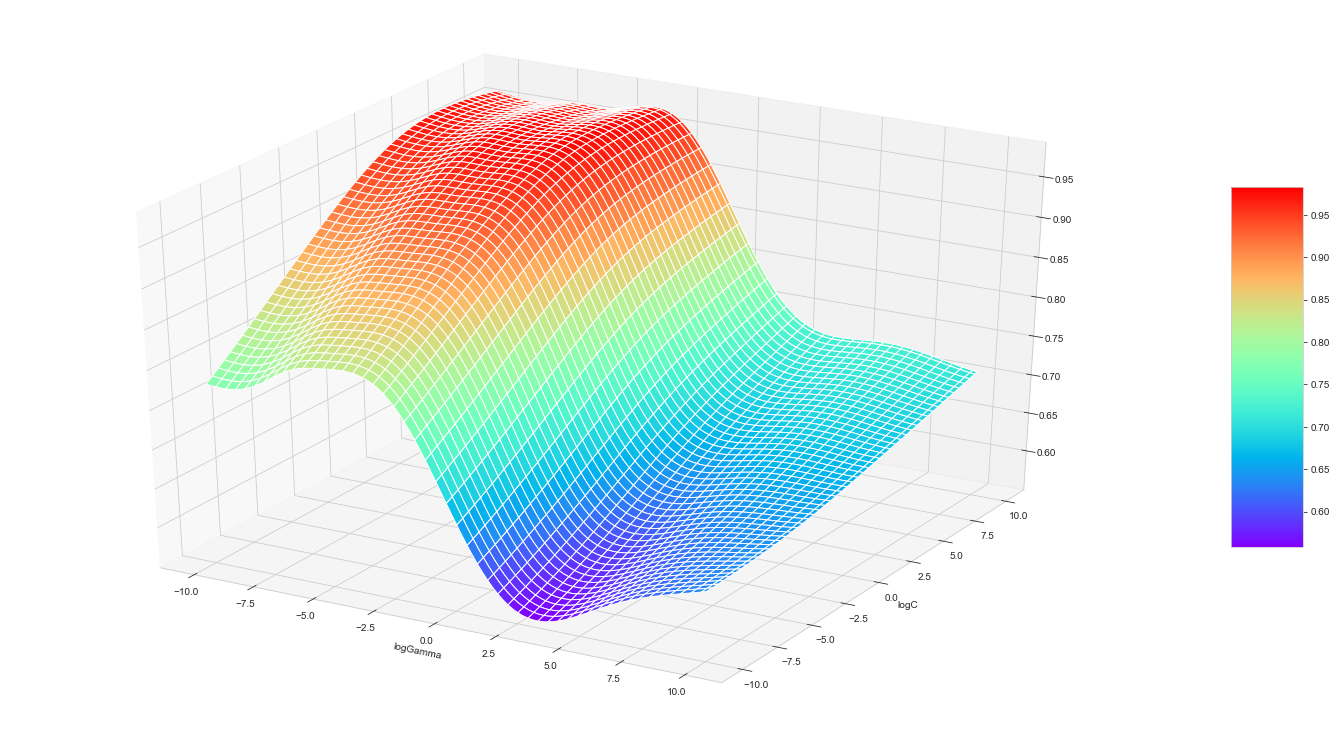

In [45]:
grid = np.linspace(-10, 10, 100)
x2, y2 = np.meshgrid(grid, grid)
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
fig = plt.figure(figsize = (20, 10))
ax = Axes3D(fig)
surf = ax.plot_surface(x2, y2, 1-np.reshape(mean_pred_t0,(100,100)), cmap=cm.rainbow)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_ylabel('logC')
ax.set_xlabel('logGamma')

(0.6, 1)

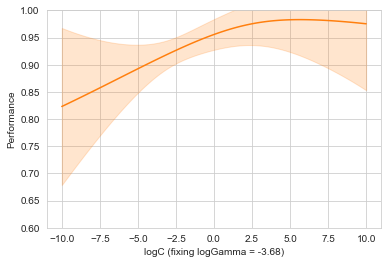

In [61]:
grid = np.linspace(-10, 10, 100)
grid2 = np.ones([100, 1])*(-3.68)
task = np.ones([100, 1])
grid3 = np.append(grid[:, None], grid2, axis = 1)
grid3 = np.append(grid3, task, axis = 1)
mean_pred_t0, var_pred = model.predict(grid3)
mean_pred_t0 = 1 - mean_pred_t0
std_pred_t0 = np.sqrt(var_pred)
fig, ax = plt.subplots()
plt.plot(grid, mean_pred_t0, label="Model", color="tab:orange")
plt.fill_between(grid, mean_pred_t0 + std_pred_t0, mean_pred_t0 - std_pred_t0, alpha=0.2, color="tab:orange")
ax.set_xlabel('logC (fixing logGamma = -3.68)')
ax.set_ylabel('Performance')
ax.set_ylim([0.6, 1])

In [ ]:
train = sparse.vstack((X_train, X_val))
target = np.concatenate((y_train.tolist(), y_val.tolist()))
clf = svm.SVC(gamma=np.exp(float(X[best][1])), C=np.exp(float(X[best][0])), probability = True)
clf.fit(train, target)
y_pred = clf.predict_proba(X_test)
y_valid_bin = LabelBinarizer().fit_transform(y_test)
clf.score(X_test, y_test)

In [ ]:
clrs = ['tab:red' if i == 0 else 'tab:blue' for i in X[:, 2]]
lbl = ['Task 0 (25% data)' if i == 0 else 'Task 1 (full data)' for i in X[:, 2]]
fig, ax = plt.subplots()
plt.scatter(range(X.shape[0]), X[:, 0], c = clrs)
ax.set_xlabel('iterations')
ax.set_ylabel('log(C)')
ax.legend()

In [ ]:
import seaborn as sns
ax = sns.scatterplot(x = range(X.shape[0]), X[:, 0], hue = lbl)
ax.set_xlabel('iterations')
ax.set_ylabel('log(C)')

In [61]:
model.train(X, y, do_optimize = True)
model_cost.train(X, c, do_optimize = True)

In [50]:
model.train(X, y)

X_test = np.append(grid[:, None], np.zeros([grid.shape[0], 1]), axis=1)

mean_pred_t0, var_pred = model.predict(X_test)
std_pred_t0 = np.sqrt(var_pred)

X_test = np.append(grid[:, None], np.ones([grid.shape[0], 1]), axis=1)

mean_pred_t1, var_pred = model.predict(X_test)
std_pred_t1 = np.sqrt(var_pred)

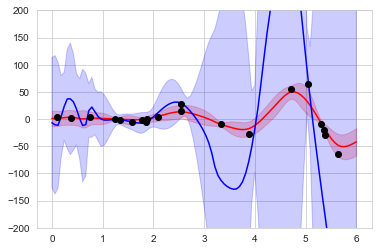

In [53]:
plt.plot(grid, mean_pred_t0, label="Model", color="red")
plt.fill_between(grid, mean_pred_t0 + std_pred_t0, mean_pred_t0 - std_pred_t0, alpha=0.2, color="red")

plt.plot(grid, mean_pred_t1, label="Model", color="blue")
plt.fill_between(grid, mean_pred_t1 + std_pred_t1, mean_pred_t1 - std_pred_t1, alpha=0.2, color="blue")


#plt.plot(grid, f_t0, "r--", label="Task-0")
#plt.plot(grid, f_t1, "b--", label="Task-1")
plt.ylim(-200, 200)
plt.plot(X[:, 0], y, "ko")
plt.show()

# Warmstarting BO

In [13]:
from robo.fmin.warmstart_mtbo import warmstart_mtbo

res = warmstart_mtbo(objective_function=objective,
                      lower=lower, upper=upper, observed_X=X[:15].tolist(), observed_y=y[:15].tolist(), num_iterations=10)

INFO:robo.fmin.warmstart_mtbo:Start iteration 0 ... 
INFO:robo.fmin.warmstart_mtbo:Optimization overhead was 8.173702 seconds
INFO:robo.fmin.warmstart_mtbo:Evaluate candidate [5.77980592 1.        ]
INFO:robo.fmin.warmstart_mtbo:Configuration achieved a performance of -148.470288
INFO:robo.fmin.warmstart_mtbo:Evaluation of this configuration took 0.000000 seconds
INFO:robo.fmin.warmstart_mtbo:Current incumbent [5.77980592] with estimated performance -148.470288
INFO:robo.fmin.warmstart_mtbo:Start iteration 1 ... 
INFO:robo.fmin.warmstart_mtbo:Optimization overhead was 4.990892 seconds
INFO:robo.fmin.warmstart_mtbo:Evaluate candidate [4.99528444 1.        ]
INFO:robo.fmin.warmstart_mtbo:Configuration achieved a performance of 73.891500
INFO:robo.fmin.warmstart_mtbo:Evaluation of this configuration took 0.000000 seconds
INFO:robo.fmin.warmstart_mtbo:Current incumbent [5.77980592] with estimated performance -148.470288
INFO:robo.fmin.warmstart_mtbo:Start iteration 2 ... 
INFO:robo.fmin.wa

In [18]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['text.usetex']=True
matplotlib.rcParams['text.latex.unicode']=True
plt.plot(grid, f_t0, "r--", label="Task-0")


C:\Users\t-fufang\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x0000024B48A94268> (for post_execute):


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 432x288 with 1 Axes>

In [14]:
plt.plot(grid, f_t0, "r--", label="Task-0")

plt.plot(grid, f_t1, "b--", label="Task-1")

plt.plot(res["X"][:15, 0], res["y"][:15], "ko", label="Initial Points")

plt.plot(res["X"][15:, 0], res["y"][15:], "go", label="BO")

plt.axvline(res["incumbents"][-1], label="incumbent")
plt.legend()
plt.show()

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 432x288 with 1 Axes>

In [22]:
def objective(x, task):
    if task == 0:
        dataset_fraction = .25
    elif task == 1:
        dataset_fraction = 1

    s_max = y_train.shape[0]
    shuffle = np.random.permutation(np.arange(s_max))
    s = int(s_max * dataset_fraction)
    train_subset = X_train[shuffle[:s]]
    train_targets_subset = y_train.to_numpy()[shuffle[:s]]

    start_time = time.time()
    # Train the SVM on the subset set
    C = np.exp(float(x[0]))
    gamma = 1#np.exp(float(x[1]))
    clf = svm.SVC(gamma=gamma, C=C, probability = True)
    clf.fit(train_subset, train_targets_subset)
    
    # Validate this hyperparameter configuration on the full validation data
    y_pred = clf.predict_proba(X_val)
    y_valid_bin = LabelBinarizer().fit_transform(y_val)
    y = 1 - roc_auc_score(y_valid_bin, y_pred, average='weighted')
    #y = 1 - clf.score(X_test, y_test)
    c = time.time() - start_time
    return y#, c


train = sparse.vstack((X_train, X_val))
target = np.concatenate((y_train.tolist(), y_val.tolist()))
def objective_function_test(x):
    start_time = time.time()
    C = np.exp(float(x[0]))
    gamma = 1#np.exp(float(x[1]))
    clf = svm.SVC(gamma=gamma, C=C, probability = True)
    clf.fit(train, target)
    y_pred = clf.predict_proba(X_test)
    y_valid_bin = LabelBinarizer().fit_transform(y_test)
    y = 1 - roc_auc_score(y_valid_bin, y_pred, average='weighted')
    #y = 1 - clf.score(X_test, y_test)
    c = time.time() - start_time
    return y#, c

In [11]:
lower = np.array([-10])#np.array([-10, -10])
upper = np.array([10])#np.array([10, 10])